In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import joblib

# 2. Load dataframe using Joblib
df = joblib.load('DFjoblib')
df.head()
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

# Data Preprocessing

- Nominal Data preprocessing with get_dummies
- Numerical Data preprocessing with StandardScaler
- Target Data preprocessing with LabelEncoder()

In [5]:
# Separating Nominal Column and Numerical column
y_col = 'Churn'
cat_cols = df.nunique()[df.nunique()<=4].keys().tolist()
cat_cols = [x for x in cat_cols if x not in y_col]
num_cols = [x for x in df.columns if x not in [y_col] + ['customerID'] + cat_cols]

In [6]:
print(num_cols)
print(cat_cols)
print(y_col)

['tenure', 'MonthlyCharges', 'TotalCharges']
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Churn


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
def transform(df):
    # Nominal Data preprocessing with dummy variables
    dfNom = pd.get_dummies(df[cat_cols])
    
    # Numerical Data preprocessing with StandardScaler
    # mean = 0 std = 1
    scaler = StandardScaler()
    dfNum = pd.DataFrame(scaler.fit_transform(df[num_cols]),columns=num_cols)
    
    # Transform target data with LabelEncoder
    le = LabelEncoder()
    dfY = pd.DataFrame(le.fit_transform(df[y_col]),columns=[y_col])
    
    # Concat all the dataframe
    output = pd.concat([dfNom,dfNum,dfY],axis='columns')
    return output

dfChurn = transform(df)
dfChurn.head()

,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,0,1,1,0,1,0,...,0,1,0,0,1,0,-1.277445,-1.160323,-0.992611,0
1,0,1,1,0,1,0,1,0,0,1,...,1,0,0,0,0,1,0.066327,-0.259629,-0.172165,0
2,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,1,-1.236724,-0.362660,-0.958066,1
3,0,1,1,0,1,0,1,0,1,0,...,1,0,1,0,0,0,0.514251,-0.746535,-0.193672,0
4,1,0,1,0,1,0,1,0,0,1,...,0,1,0,0,1,0,-1.236724,0.197365,-0.938874,1


In [8]:
# Train test splitting 80% - 20% 
# All features exclude customerID
from sklearn.model_selection import train_test_split

xtrain, xtes, ytrain, ytes = train_test_split(
    dfChurn[dfChurn.columns[0:-1]], dfChurn['Churn'], train_size=.8,
    random_state=100
)
print(xtrain.shape,xtes.shape,ytrain.shape,ytes.shape)

(5634, 39) (1409, 39) (5634,) (1409,)


# Build Classification Model

- Logistic Regression
- DecisionTree
- Random Forrest
- K-Nearest Neighbor

In [9]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import (DecisionTreeClassifier,plot_tree,export_graphviz)
from sklearn.ensemble import RandomForestClassifier

- Most popular $k$ value:
    1. Hitung akar kuadrat dari jumlah $x$ training $\displaystyle \sqrt {n_(x_\textrm{training})}$
    2. Pilih angka yang ganjil sebagai $k$

In [10]:
# K-Nearest Neighbors
# K value for KNeighbors Classifier
def k(x):
    k = int(np.sqrt(x))
    if k % 2 == 0:
        k+=1
        return k
    else:
        return k

A Good Model is not the one that gives accurate predictions on the known data or training data but the one which gives good predictions on the new data and avoids overfitting and underfitting.

                          Average Cross Validation Score
Logistic Regression                             0.807775
KNeighbors Classifier                           0.799787
Random Forest Classifier                        0.792864
Decision Tree Classifier                        0.740504


<ipython-input-11-442b13093c22>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


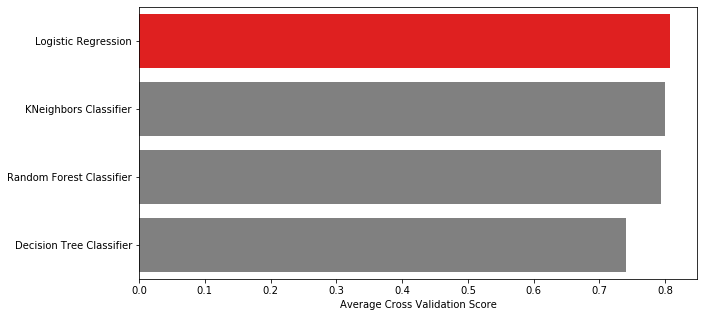

In [11]:
# Estimating Accuracy of set data into different types of classification model
def csv(xtrain,ytrain):
    models = [LogisticRegression(solver='liblinear'),KNeighborsClassifier(n_neighbors=k(len(xtrain))),DecisionTreeClassifier(),RandomForestClassifier()]
    score = []
    for model in models:
        cv_score = cross_val_score(
            model,xtrain,ytrain,
            scoring='accuracy',cv = 5)
        score.append(cv_score)

    output = []
    for i in range(4):
        output.append(np.mean(score[i]))
    crossval = pd.DataFrame(output,index=['Logistic Regression','KNeighbors Classifier','Decision Tree Classifier','Random Forest Classifier'],columns=['Average Cross Validation Score'])
    return crossval.sort_values(by='Average Cross Validation Score', ascending=False)
crossval = csv(xtrain,ytrain)
print(crossval)

# Barplot Models Cross Validation Score
palette = {'Logistic Regression':'red','KNeighbors Classifier':'grey','Decision Tree Classifier':'grey','Random Forest Classifier':'grey'}
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(y=crossval.index,x=crossval['Average Cross Validation Score'],palette=palette,ax=ax)
fig.show()

In [12]:
# Evaluation Metrics
from sklearn.metrics import (roc_curve, roc_auc_score,
    accuracy_score, recall_score, precision_score, confusion_matrix,
    f1_score, balanced_accuracy_score, precision_recall_fscore_support)

                          Accuracy Score  bACC Score  Precision Score  \
Logistic Regression             0.786373    0.708229         0.626140   
Random Forest Classifier        0.766501    0.680728         0.585139   
KNeighbors Classifier           0.743080    0.667887         0.530220   
Decision Tree Classifier        0.722498    0.649670         0.490862   

                          Recall Score  F1 Score  model_roc_auc  
Logistic Regression           0.536458  0.577840       0.708229  
Random Forest Classifier      0.492188  0.534653       0.680728  
KNeighbors Classifier         0.502604  0.516043       0.667887  
Decision Tree Classifier      0.489583  0.490222       0.649670  


<ipython-input-13-65347eb9d9f1>:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


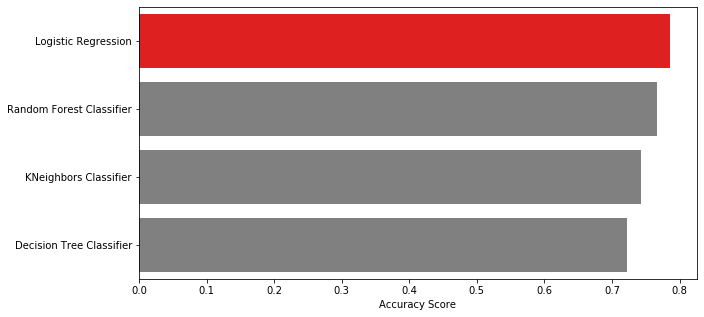

In [13]:
# Evaluation Metrics

def EvaMetrics(algorithm, xtrain, ytrain, xtes):
    # Model
    algorithm.fit(xtrain,ytrain)
    prediction = algorithm.predict(xtes)
    probability = algorithm.predict_proba(xtes)
    
    # Evaluation Metrics
    model_roc_auc = roc_auc_score(ytes,prediction)
    f1 = f1_score(ytes,prediction)
    rec = recall_score(ytes,prediction)
    pre = precision_score(ytes,prediction)
    accuracy = accuracy_score(ytes, prediction)
    bacc = balanced_accuracy_score(ytes,prediction)
    allscore = [accuracy,bacc,pre,rec,f1,model_roc_auc]
    return allscore

all_score=[]
best_algorithm = [LogisticRegression(solver='liblinear'),KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier()]
for item in best_algorithm :
    score = EvaMetrics(item,xtrain,ytrain,xtes)
    all_score.append(score)
    
df_score = pd.DataFrame(all_score,index=['Logistic Regression', 'KNeighbors Classifier','Decision Tree Classifier','Random Forest Classifier'],
                        columns=['Accuracy Score','bACC Score','Precision Score','Recall Score','F1 Score','model_roc_auc'])
df_score = df_score.sort_values(by='model_roc_auc',ascending=False)
print(df_score)

# Barplot Models Eva Metrics
palette = {'Logistic Regression':'red','KNeighbors Classifier':'grey','Decision Tree Classifier':'grey','Random Forest Classifier':'grey'}
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(y=df_score.index,x=df_score[df_score.columns[0]],ax=ax,palette=palette)
fig.show()

In [14]:
# Random Forest
rf = RandomForestClassifier(n_estimators=10,max_depth=3,criterion='gini')
rf = rf.fit(xtrain,ytrain)

dot_rf = export_graphviz(rf.estimators_[0], out_file='RandomTree.dot', 
                           feature_names=dfChurn.columns[0:-1], 
                           class_names=['Not Churn','Churn'],
                           filled=True, rounded=True,
                           special_characters=True)

![DecisionTree](randomforest.png)

In [15]:
# Decision Tree
from sklearn import tree

clf = DecisionTreeClassifier(criterion='gini',max_depth=3)
clf = clf.fit(xtrain,ytrain)

dot_dt = export_graphviz(clf, out_file='tree.dot', 
                           feature_names=dfChurn.columns[0:-1], 
                           class_names=['Not Churn','Churn'],
                           filled=True, rounded=True,
                           special_characters=True)

![DecisionTree](tree.png)

<ipython-input-16-c853ef0f38d3>:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


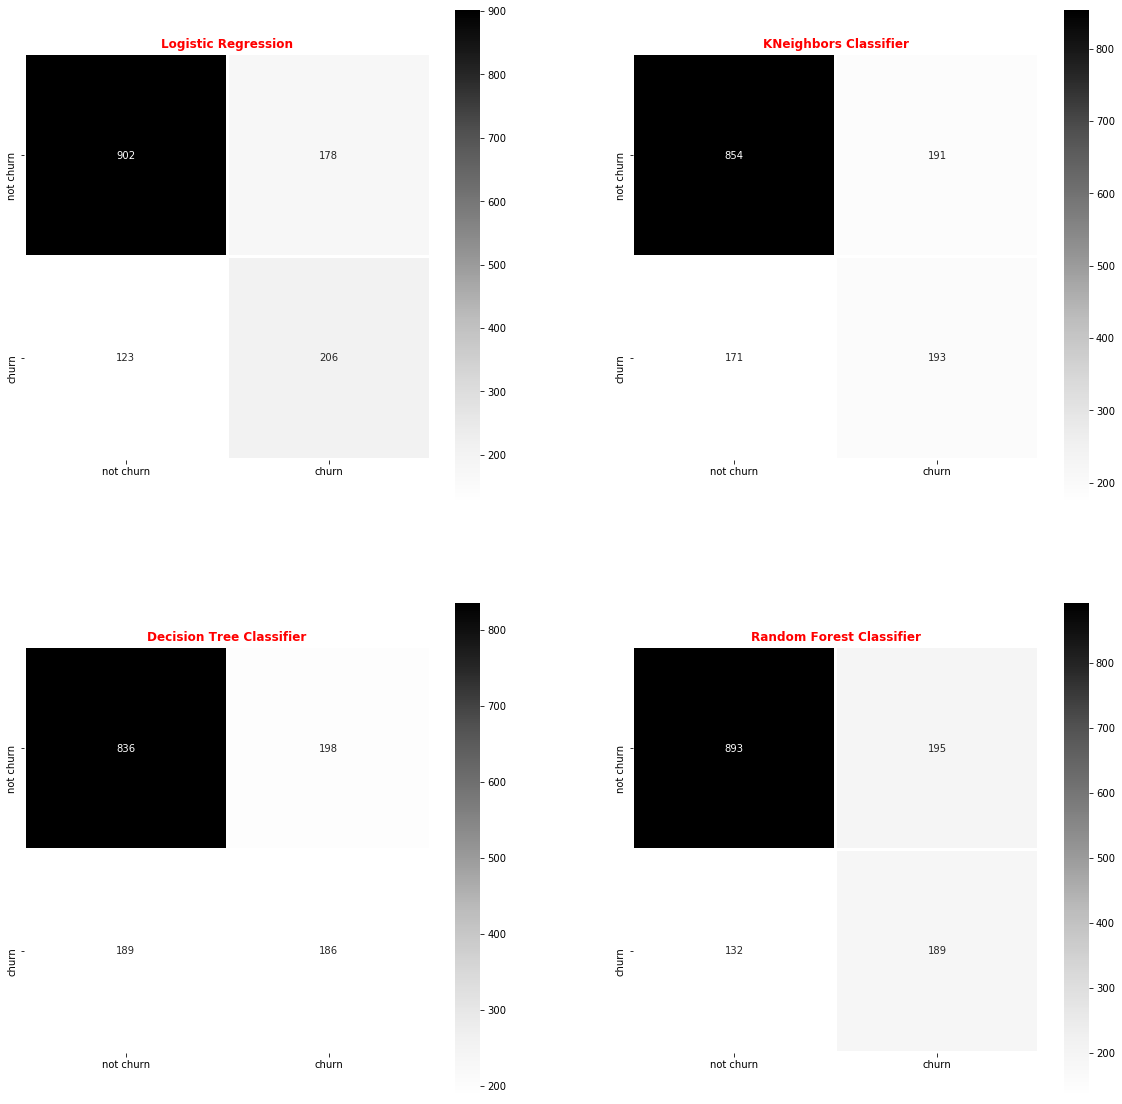

In [16]:
# Finding the confusion Matrix for models
def confusionMatrix(xtrain,ytrain,xtes,ytes):
    algorithm = [LogisticRegression(solver='liblinear'),KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier()]
    arr = []
    for item in algorithm:
        item.fit(xtrain,ytrain)
        prediction = item.predict(xtes)
        cm = confusion_matrix(prediction,ytes)
        arr.append(cm)
    return arr
arr = confusionMatrix(xtrain,ytrain,xtes,ytes)

fig, (ax1,ax2) = plt.subplots(2,2,figsize=(20,20))
sns.heatmap(arr[0],annot=True,fmt = "d",square = True,
            xticklabels=["not churn","churn"],
            yticklabels=["not churn","churn"],
            linewidths = 2,linecolor="w",cmap='Greys',ax=ax1[0])
ax1[0].set_title('Logistic Regression',color='red',fontweight='bold')

sns.heatmap(arr[1],annot=True,fmt = "d",square = True,
            xticklabels=["not churn","churn"],
            yticklabels=["not churn","churn"],
            linewidths = 2,linecolor="w",cmap='Greys',ax=ax1[1])
ax1[1].set_title('KNeighbors Classifier',color='red',fontweight='bold')

sns.heatmap(arr[2],annot=True,fmt = "d",square = True,
            xticklabels=["not churn","churn"],
            yticklabels=["not churn","churn"],
            linewidths = 2,linecolor="w",cmap='Greys',ax=ax2[0])
ax2[0].set_title('Decision Tree Classifier',color='red',fontweight='bold')

sns.heatmap(arr[3],annot=True,fmt = "d",square = True,
            xticklabels=["not churn","churn"],
            yticklabels=["not churn","churn"],
            linewidths = 2,linecolor="w",cmap='Greys',ax=ax2[1])
ax2[1].set_title('Random Forest Classifier',color='red',fontweight='bold')
fig.show()

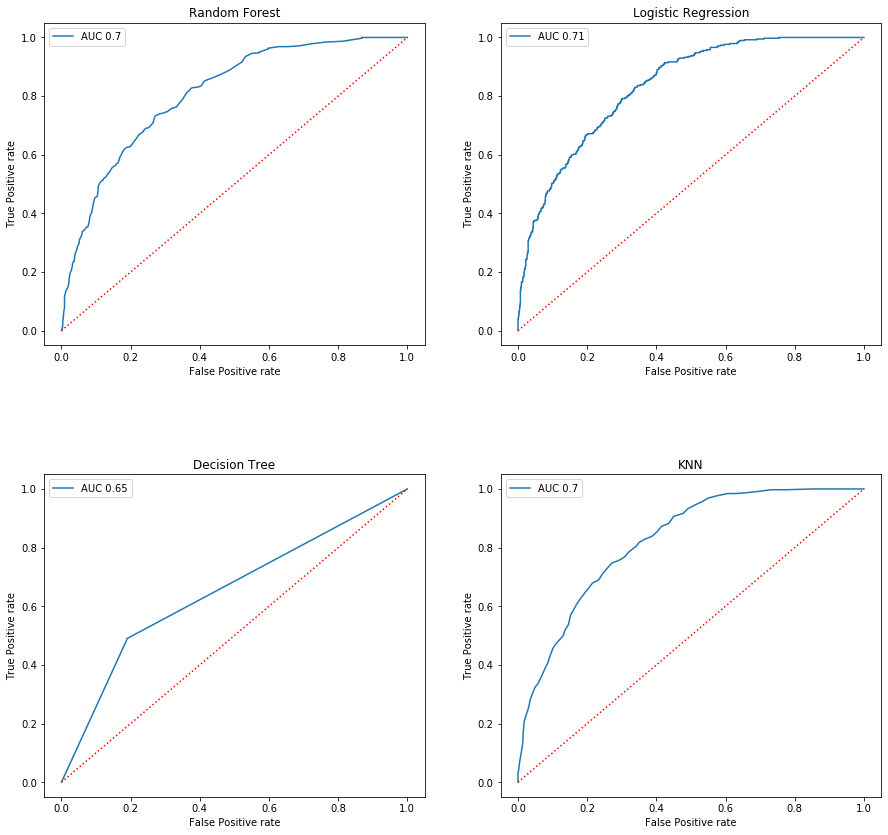

In [17]:
# ROC AUC
RF = RandomForestClassifier()
LR = LogisticRegression(solver='liblinear')
DT = DecisionTreeClassifier()
KNN = KNeighborsClassifier(n_neighbors=k(len(xtrain)))

RF.fit(xtrain,ytrain)
LR.fit(xtrain,ytrain)
DT.fit(xtrain,ytrain)
KNN.fit(xtrain,ytrain)

# Plot ROC
fpr1, tpr1, thres1 = roc_curve(ytes, RF.predict_proba(xtes)[:,1])
auc1 = roc_auc_score(ytes, RF.predict(xtes))

fpr2, tpr2, thres2 = roc_curve(ytes, LR.predict_proba(xtes)[:,1])
auc2 = roc_auc_score(ytes, LR.predict(xtes))

fpr3, tpr3, thres3 = roc_curve(ytes, DT.predict_proba(xtes)[:,1])
auc3 = roc_auc_score(ytes, DT.predict(xtes))

fpr4, tpr4, thres4 = roc_curve(ytes, KNN.predict_proba(xtes)[:,1])
auc4 = roc_auc_score(ytes, KNN.predict(xtes))

plt.figure(figsize=(15,10))
plt.subplots_adjust(top=1.2,hspace=0.4)
plt.subplot(221)
plt.plot(fpr1, tpr1,label=f'AUC {round(auc1,2)}')
plt.plot([0,1], [0,1], 'r:')
plt.legend(loc='upper left');plt.title('Random Forest')
plt.xlabel('False Positive rate');plt.ylabel('True Positive rate')

plt.subplot(222)
plt.plot(fpr2, tpr2,label=f'AUC {round(auc2,2)}')
plt.plot([0,1], [0,1], 'r:')
plt.legend(loc='upper left');plt.title('Logistic Regression')
plt.xlabel('False Positive rate');plt.ylabel('True Positive rate')

plt.subplot(223)
plt.plot(fpr3, tpr3,label=f'AUC {round(auc3,2)}')
plt.plot([0,1], [0,1], 'r:')
plt.legend(loc='upper left');plt.title('Decision Tree')
plt.xlabel('False Positive rate');plt.ylabel('True Positive rate')

plt.subplot(224)
plt.plot(fpr4, tpr4,label=f'AUC {round(auc4,2)}')
plt.plot([0,1], [0,1], 'r:')
plt.legend(loc='upper left');plt.title('KNN')
plt.xlabel('False Positive rate');plt.ylabel('True Positive rate')

plt.show()

# Best Model based on:

- Cross Validation Score
- Evaluation Metrics
- Confusion Metrics

In [18]:
# Logistic Regression

def Model(algorithm, xtrain, ytrain, xtes):
    # Model
    algorithm.fit(xtrain,ytrain)
    prediction = algorithm.predict(xtes)
    probability = algorithm.predict_proba(xtes)
    
    # Evaluation Metrics
    model_roc_auc = roc_auc_score(ytes,prediction)
    pre, rec, f1, sup = precision_recall_fscore_support(ytes, prediction)
    print('Accuracy = ', accuracy_score(ytes, prediction))
    print('Balance Accuracy Score (bACC) = ',balanced_accuracy_score(ytes,prediction))
    print('Precision (0)(1) =',  pre)
    print('Recall (0)(1)] =', rec)
    print('F1 Score (0)(1) =', f1)
    print('Area Under Curve = ', model_roc_auc)

LR = LogisticRegression(solver='liblinear')
Model(LR,xtrain,ytrain,xtes)

Accuracy =  0.7863733144073811
Balance Accuracy Score (bACC) =  0.7082291666666667
Precision (0)(1) = [0.83518519 0.62613982]
Recall (0)(1)] = [0.88       0.53645833]
F1 Score (0)(1) = [0.85700713 0.57784011]
Area Under Curve =  0.7082291666666668


In [19]:
from sklearn.pipeline import make_pipeline

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [21]:
from sklearn.model_selection import GridSearchCV
penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [10, 100, 1000, 10000]
param = {'penalty': penalty, 'solver': solver, 'max_iter': max_iter}

In [22]:
model = LogisticRegression()
modelgs = GridSearchCV(
    model,
    param,
    cv = 5
)
modelgs.fit(xtrain, ytrain)

C:\Users\Yuji\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Yuji\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Yuji\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Libli

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'max_iter': [10, 100, 1000, 10000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scorin

In [23]:
modelgs.best_params_

{'max_iter': 10, 'penalty': 'l1', 'solver': 'saga'}

In [99]:
final_model = make_pipeline(
    LogisticRegression(solver='saga',max_iter=10,penalty='none')
)
final_model.fit(xtrain,ytrain)
final_model.score(xtes,ytes)

from scipy.sparse import csr_matrix
one_hot_columns = dfChurn.columns[:36]
scaler = StandardScaler()
scaler.fit(df[num_cols])

def trans(data):
    dF = pd.DataFrame(data,index=[0])
    dF = pd.get_dummies(dF)
    dF = dF.reindex(columns=one_hot_columns, fill_value=0)
    ss = scaler.transform(data[num_cols])
    num = pd.DataFrame(ss,columns=num_cols)
    output = pd.concat([dF,num],axis='columns')
    return output

C:\Users\Yuji\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [106]:
import joblib
import pickle

joblib.dump(final_model,'FinalModeljoblib')
joblib.dump(dfChurn,'dfchurnjoblib')

['dfchurnjoblib']

In [104]:
df.iloc[0].values

array(['7590-VHVEG', 'Female', 'No', 'Yes', 'No', 1, 'No', 'No', 'DSL',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'Month-to-month', 'Yes',
       'Electronic check', 29.85, 29.85, 'No'], dtype=object)

In [105]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [110]:
len(df.columns[1:20])

19

In [113]:
data = ['Female', 'No', 'Yes', 'No', 1, 'No', 'No', 'DSL','No', 'Yes', 'No', 'No', 'No', 'No', 'Month-to-month', 'Yes','Electronic check', 29.85, 29.85]
len(data)

19

In [118]:
data = [['Female', 'No', 'Yes', 'No', 1, 'No', 'No', 'DSL','No', 'Yes', 'No', 'No', 'No', 'No', 'Month-to-month', 'Yes','Electronic check', 29.85, 29.85]]
dfx = pd.DataFrame(data,columns=df.columns[1:20])
dfx

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85


In [ ]:
my